In [ ]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt
import hierarchical as hrc
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0")
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
g = torch.load('FILE_PATH').to(device) # 'FILE_PATH' in store_matrices.py

vocab_dict = tokenizer.get_vocab()
vocab_list = [None] * (max(vocab_dict.values()) + 1)
for word, index in vocab_dict.items():
    vocab_list[index] = word

In [3]:
cats, G, sorted_keys = hrc.get_categories('noun')

dirs = {k: hrc.estimate_cat_dir(v, g, vocab_dict) for k, v in cats.items()}

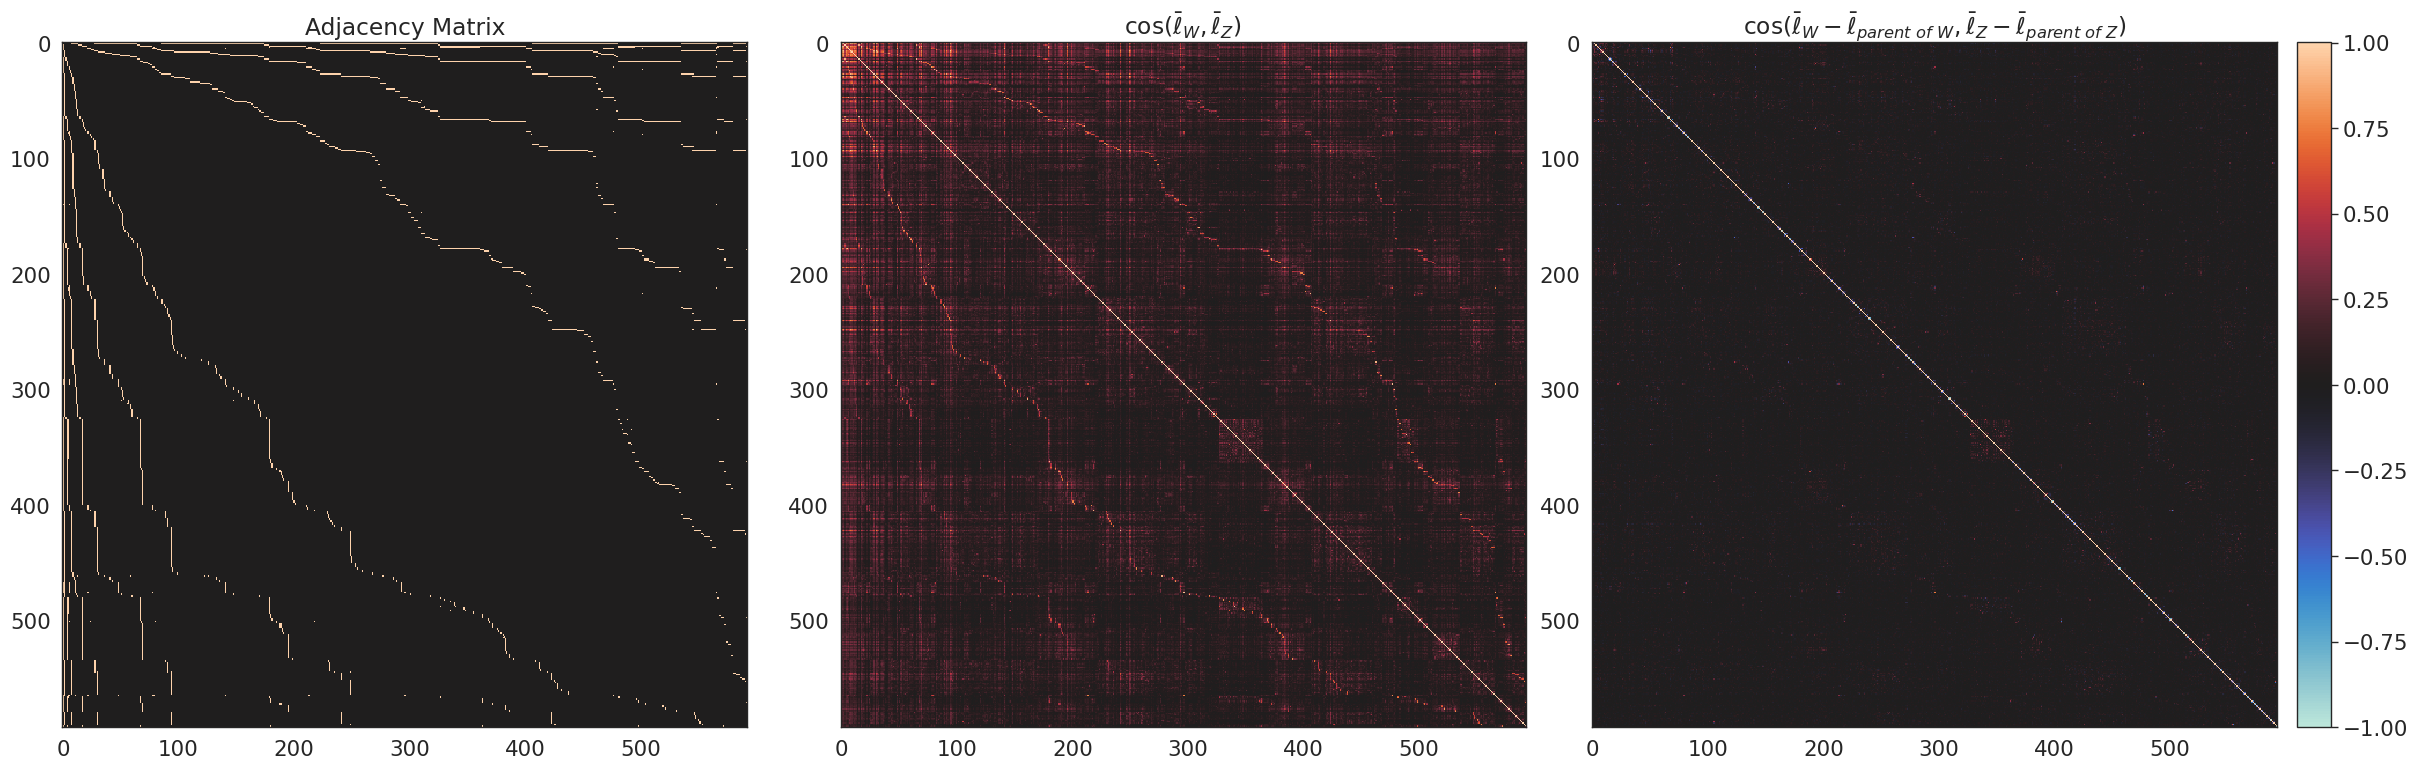

In [4]:
tc_G = nx.algorithms.dag.transitive_closure(G)
adj_mat = nx.adjacency_matrix(tc_G, nodelist=sorted_keys).todense()
adj_mat = adj_mat + adj_mat.T

lda_dirs = torch.stack([v['lda'] for k, v in dirs.items()])
lda_dirs = lda_dirs / lda_dirs.norm(dim = 1).unsqueeze(1)

child_parent = {}

for node in sorted_keys:
    if len(list(G.predecessors(node))) > 0:
        parent = list(G.predecessors(node))[0]
        child_parent.update({node:  dirs[node]['lda'] - dirs[parent]['lda']})
    
lda_diff = torch.stack([lda_dirs[0]] + [v for k, v in child_parent.items()])
lda_diff = lda_diff / lda_diff.norm(dim = 1).unsqueeze(1)

mats = [adj_mat,
        (lda_dirs @ lda_dirs.T).cpu().numpy(),
        (lda_diff @ lda_diff.T).cpu().numpy()]

titles = ["Adjacency Matrix",
          rf'$\cos(\bar{{\ell}}_{{W}}, \bar{{\ell}}_{{Z}})$',
          rf'$\cos(\bar{{\ell}}_{{W}} - \bar{{\ell}}_{{parent \,\, of \,\, W}}, \bar{{\ell}}_{{Z}} - \bar{{\ell}}_{{parent \,\, of \,\,Z}})$']
 
hrc.cos_heatmap(mats, titles, figsize = (25, 8),
                use_absvals=False,
                save_as = "noun_single_three_heatmap")

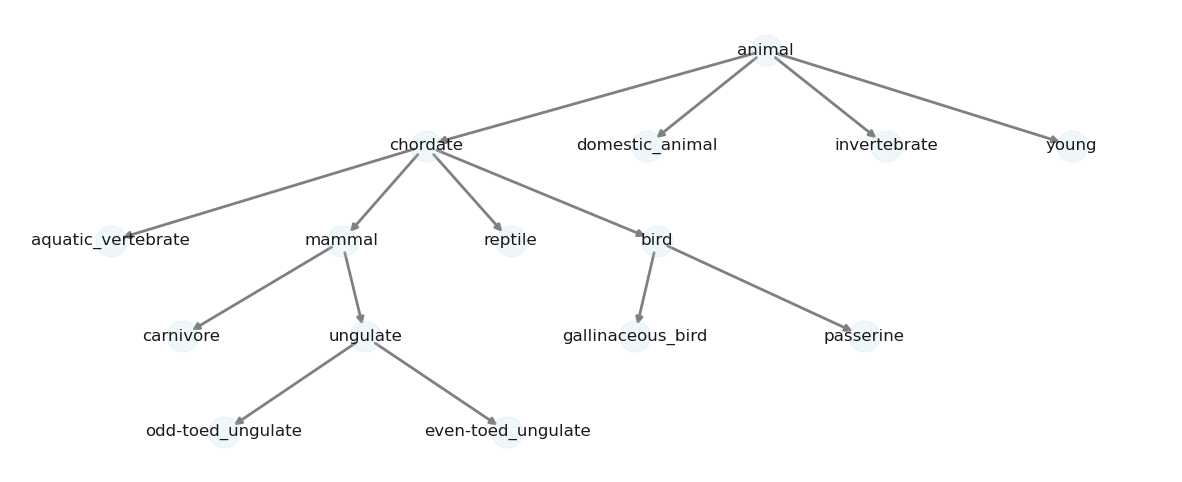

In [5]:
from networkx.drawing.nx_agraph import graphviz_layout
start_node = 'animal.n.01'
sub_G =nx.bfs_tree(G, start_node)
sub_G =  nx.DiGraph(G.subgraph(sub_G.nodes()))

pos = graphviz_layout(sub_G, prog='dot')
labels = {node: node.split('.', 1)[0] for node in sub_G.nodes()}

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
nx.draw_networkx_nodes(sub_G, pos, node_size=500, node_color='lightblue', alpha=0.2)
nx.draw_networkx_edges(sub_G, pos, edge_color='gray', width=2)
nx.draw_networkx_labels(sub_G, pos, labels=labels)

plt.axis('off')
plt.savefig(f"figures/sub_graph_tree.pdf", bbox_inches='tight')
plt.show()

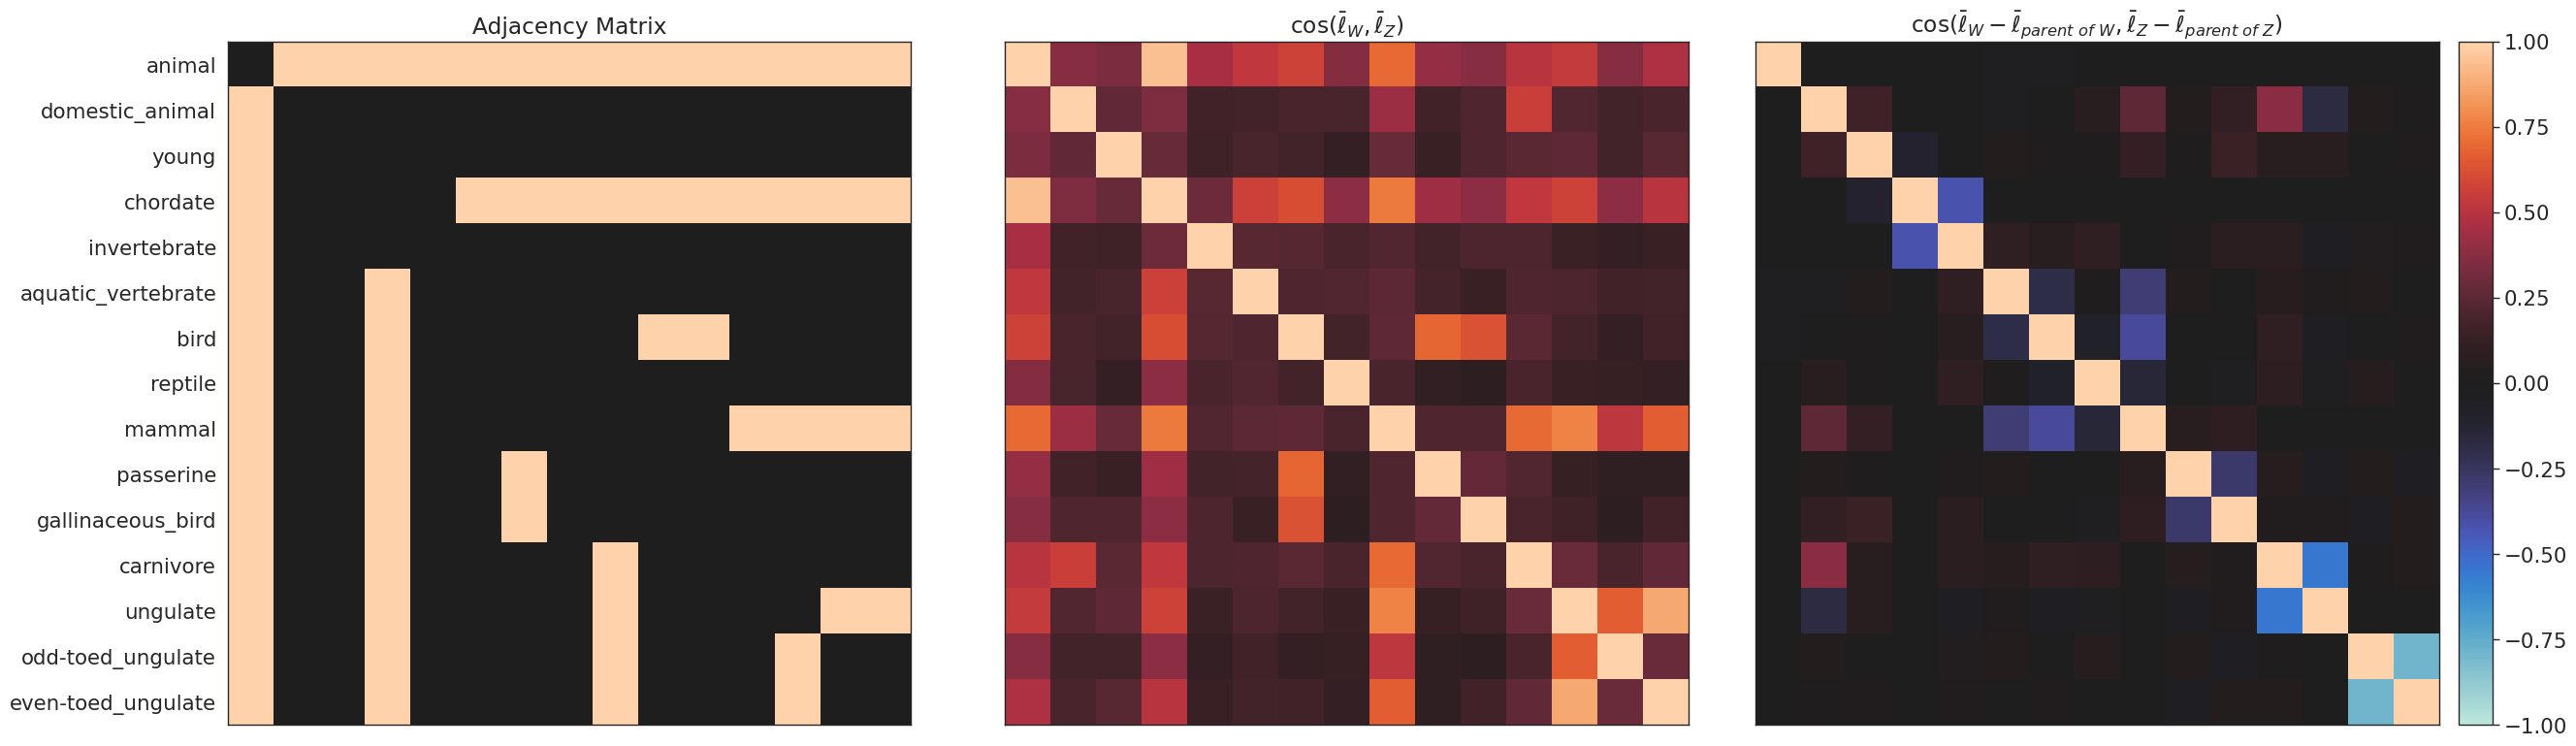

In [6]:
sub_sorted_keys = list(nx.topological_sort(sub_G))
tc_G = nx.algorithms.dag.transitive_closure(G.subgraph(sub_sorted_keys))
adj_mat = nx.adjacency_matrix(tc_G, nodelist = sub_sorted_keys).todense()
adj_mat = adj_mat + adj_mat.T

lda_dirs = torch.stack([dirs[node]['lda'] for node in sub_sorted_keys])
lda_dirs = lda_dirs / lda_dirs.norm(dim = 1).unsqueeze(1)

child_parent = {}

for node in sub_sorted_keys:
    if len(list(sub_G.predecessors(node))) > 0:
        parent = list(sub_G.predecessors(node))[0]
        child_parent.update({node: dirs[node]['lda'] - dirs[parent]['lda']})
    
lda_diff = torch.stack([lda_dirs[0]] + [v for k, v in child_parent.items()])
lda_diff = lda_diff / lda_diff.norm(dim = 1).unsqueeze(1)

mats = [adj_mat,
        (lda_dirs @ lda_dirs.T).cpu().numpy(),
        (lda_diff @ lda_diff.T).cpu().numpy()]

titles = ["Adjacency Matrix",
          rf'$\cos(\bar{{\ell}}_{{W}}, \bar{{\ell}}_{{Z}})$',
          rf'$\cos(\bar{{\ell}}_{{W}} - \bar{{\ell}}_{{parent \,\, of \,\, W}}, \bar{{\ell}}_{{Z}} - \bar{{\ell}}_{{parent \,\, of \,\,Z}})$']

hrc.cos_heatmap(mats, titles, figsize = (27, 8),
                labels = [node.split('.', 1)[0] for node in sub_sorted_keys],
                use_absvals=False,
                save_as = "sub_noun_single_three_heatmap")